# Clusteranalyse

Schritte zur Vorbereitung, später evtl. schon im Preprossessing erledigt:

Format
- Datumsspalte in Jahr, Monat, Tag trennen

Daten entfernen
- **Zeilen** aus 2014 und 2025 entfernen, weil zu wenige Datenpunkte
- **Spalten** mit zu vielen fehlenden Werten entfernen (cut-off: 53% missing values)
- Alle Einträge für **Tehran** entfernen, weil die Stadt durch ihre extrem hohen Schadstoffwerte die Clusteranalyse verzerrt

Aktuell auch noch relevant, aber im großen Datensatz vielleicht nicht mehr
- Bestimmen, in welchen der 95 Städte für **alle Schadstoffe** Messwerte vorliegen --> 54 Städte

Clusteranalyse
- StandardScaler und KMeans importieren
- Liste der Schadstoffe definieren (pollutants)
- gruppierten ("City") und reduzierten ("dropna") mit Mittelwerten ("mean") df nach Städten und Schadstoffen für als Datengrundlage der Clusteranalyse erstellen (**df_cluster**). df-cluster hat 53 Zeilen (Städte) und 6 Spalten (Schadstoffe)
- Daten skalieren (**df_cluster_scaled**)
- mit Ellbow-Methode optimale Clusteranzahl bestimmen --> 5 Cluster (Silhouette wurde auch getestet, brachte keinen Mehrwert)
- mit Kmeans Clusterzuordnung durchführen (**df_cluster_numbers**)

Output


In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [4]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [5]:
df = pd.read_csv("../data/cleaned_data.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,Wind-speed,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.07,15.45,"269,997.00",0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26,11.39,"124,579.00",0.10,25.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.31,14.29,"193,814.00",0.10,14.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.80,13.04,"146,631.00",0.10,21.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.21,16.37,NaN,0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.isna().sum()

Year                 0
Month                0
Day                  0
Country              0
City                 0
Latitude          2827
Longitude         2827
Population     1330384
Co              631350
No2             286040
O3              373831
Pm10            341643
Pm25            262612
Pressure        392601
So2             532580
Temperature     386303
Wind-gust       918398
Wind-speed      412176
Dew             694692
Humidity        388057
Tavg            290171
Tmin            315263
Tmax            317022
Prcp            652617
Wdir            522982
Wspd            453565
Pres            489606
dtype: int64

In [8]:
# # Data preparation: Manipulating the 'Date' column

# # Convert 'Date' column to datetime
# df['Date'] = pd.to_datetime(df['Date'])

# # Split 'Date' column into 'year', 'month' and 'day'
# df['year'] = df['Date'].dt.year
# df['month'] = df['Date'].dt.month
# df['day'] = df['Date'].dt.day

# # Remove 'Date' column
# if 'Date' in df.columns:
#     df.drop(columns=['Date'], inplace=True)

In [9]:
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,Wind-speed,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.07,15.45,"269,997.00",0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26,11.39,"124,579.00",0.10,25.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.31,14.29,"193,814.00",0.10,14.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.80,13.04,"146,631.00",0.10,21.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.21,16.37,NaN,0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Tehran komplett entfernen, weil die Schadstoffwerte zu sehr von allen übrigen Städten abweichen
df = df[df["City"] != "Tehran"]

In [12]:
print("Tehran noch im DataFrame?", "Tehran" in df["City"].values)

Tehran noch im DataFrame? False


In [13]:
df['City'].nunique()

615

In [14]:
# Display the first 5 rows of the dataframe
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,Wind-speed,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.07,15.45,"269,997.00",0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26,11.39,"124,579.00",0.10,25.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.31,14.29,"193,814.00",0.10,14.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.80,13.04,"146,631.00",0.10,21.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.21,16.37,NaN,0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.shape

(1691224, 27)

In [16]:
# Spalten mit zu vielen fehlenden Werten entfernen

# Berechnen, wie viele Prozent der Werte pro Spalte fehlen
missing_percent = df.isna().mean() * 100  

# Spalten auswählen, die weniger als 50% fehlende Werte haben
df_cleaned = df.loc[:, missing_percent <= 53]

# Ergebnis ausgeben
print(f"Anzahl der entfernten Spalten: {df.shape[1] - df_cleaned.shape[1]}")
print("Übrige Spalten:", df_cleaned.columns)


Anzahl der entfernten Spalten: 2
Übrige Spalten: Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'Pressure', 'So2', 'Temperature',
       'Wind-speed', 'Dew', 'Humidity', 'Tavg', 'Tmin', 'Tmax', 'Prcp', 'Wdir',
       'Wspd', 'Pres'],
      dtype='object')


In [17]:
df_cleaned["City"].nunique()

615

In [ ]:
# # Mit Heatmap herausfinden, welche Städte für welche Schadstoffe fehlende Werte haben

# # Liste der Schadstoff-Features für das Clustering
# pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# # DataFrame mit den Schadstoffen pro Stadt erstellen
# df_missing = df_cleaned.groupby("City")[pollutants].mean()

# # Boolean-Maske für fehlende Werte erstellen (True = fehlend, False = vorhanden)
# missing_data = df_missing.isna()

# # Größe der Grafik anpassen
# plt.figure(figsize=(8, 20))

# # Heatmap zeichnen (dunklere Farben = mehr fehlende Werte)
# sns.heatmap(missing_data, cmap="coolwarm", cbar=False, linewidths=0.5)

# # Achsentitel setzen
# plt.xlabel("Schadstoffe")
# plt.ylabel("Städte")
# plt.title("Heatmap der fehlenden Werte pro Stadt und Schadstoff")


In [ ]:
# missing_per_city = df_missing.isna().sum(axis=1)
# missing_per_city_sorted = missing_per_city.sort_values(ascending=False)
# print(missing_per_city_sorted.to_string())


## Code für Clusteranalyse (K-Means) zur Schadstoffbelastung

Input: df_cleaned

Output:

In [20]:
# Liste der Schadstoff-Features für das Clustering
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

In [21]:
# Clusteranalyse zur Schadstoffbelastung

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Durchschnittliche Schadstoffwerte pro Stadt berechnen
df_pollutants = df_cleaned.groupby("City")[pollutants].mean().dropna()

In [22]:
df_pollutants.head()

,Co,No2,O3,So2,Pm10,Pm25
City,,,,,,
Abu dhabi,0.10,12.20,27.72,4.99,79.44,97.85
Adana,4.05,11.25,16.47,4.18,31.49,68.21
Adapazarı,18.37,12.70,16.36,19.66,38.06,72.09
Adelaide,2.45,20.03,23.99,8.58,13.29,16.64
Aguascalientes,7.19,16.04,44.53,4.89,70.22,106.46


In [23]:
df_pollutants.shape

(405, 6)

In [24]:
# Daten skalieren (K-Means ist empfindlich gegenüber unterschiedlichen Skalen)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pollutants)

# Ergebnis als DataFrame zurückgeben
df_pollutants_scaled = pd.DataFrame(df_scaled, index=df_pollutants.index, columns=pollutants)

# Überprüfen, ob die Daten korrekt vorbereitet sind
df_pollutants_scaled.head()

,Co,No2,O3,So2,Pm10,Pm25
City,,,,,,
Abu dhabi,-0.63,0.28,0.83,0.02,2.47,1.41
Adana,-0.18,0.11,-0.43,-0.09,0.02,0.34
Adapazarı,1.44,0.36,-0.45,1.95,0.36,0.48
Adelaide,-0.36,1.63,0.41,0.49,-0.91,-1.52
Aguascalientes,0.18,0.94,2.72,0.00,2.00,1.72


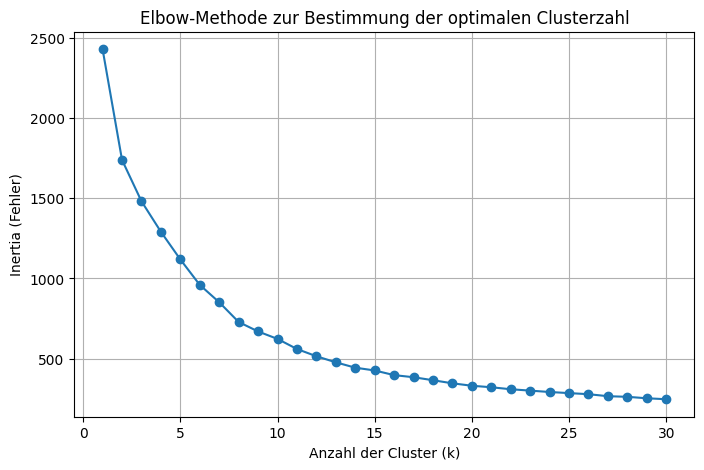

In [25]:
# Teste verschiedene Clusterzahlen (k = 1 bis 10)
inertia = []
k_values = range(1, 31)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pollutants_scaled)
    inertia.append(kmeans.inertia_)  # Speichert den Fehler (Inertia)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Fehler)")
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusterzahl")
plt.grid(True);

In [26]:
# K-Means-Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_pollutants_scaled["Cluster"] = kmeans.fit_predict(df_pollutants_scaled)
df_pollutants_scaled.head()

,Co,No2,O3,So2,Pm10,Pm25,Cluster
City,,,,,,,
Abu dhabi,-0.63,0.28,0.83,0.02,2.47,1.41,1
Adana,-0.18,0.11,-0.43,-0.09,0.02,0.34,3
Adapazarı,1.44,0.36,-0.45,1.95,0.36,0.48,2
Adelaide,-0.36,1.63,0.41,0.49,-0.91,-1.52,0
Aguascalientes,0.18,0.94,2.72,0.00,2.00,1.72,1


In [27]:
# Neue Cluster-Zuordnung der Städte anzeigen
pollutants_cluster_numbers = df_pollutants_scaled[["Cluster"]].sort_values(by="Cluster")
pollutants_cluster_numbers

,Cluster
City,
Granada,0
Indianapolis,0
Rome,0
Rijeka,0
Richmond,0
...,...
Gwangju,3
Guiyang,3
Hong kong,3


In [28]:
cluster_counts = pollutants_cluster_numbers["Cluster"].value_counts().sort_index()
cluster_counts


Cluster
0    194
1     61
2     19
3    130
4      1
Name: count, dtype: int64

In [29]:
cluster_1_cities = pollutants_cluster_numbers[pollutants_cluster_numbers["Cluster"] == 1]


In [30]:
cluster_1_cities

,Cluster
City,
Zhengzhou,1
Nanchang,1
Nanjing,1
Santiago,1
Zhuzhou,1
...,...
Chongqing,1
Changsha,1
Hangzhou,1


In [31]:
df_pollutants_with_cluster_numbers = pd.concat([df_pollutants, pollutants_cluster_numbers], axis=1)
df_pollutants_with_cluster_numbers.head()

,Co,No2,O3,So2,Pm10,Pm25,Cluster
City,,,,,,,
Abu dhabi,0.10,12.20,27.72,4.99,79.44,97.85,1
Adana,4.05,11.25,16.47,4.18,31.49,68.21,3
Adapazarı,18.37,12.70,16.36,19.66,38.06,72.09,2
Adelaide,2.45,20.03,23.99,8.58,13.29,16.64,0
Aguascalientes,7.19,16.04,44.53,4.89,70.22,106.46,1


In [32]:
df_pollutants_with_cluster_numbers.to_csv("df_pollutants.csv", index=True)  # Index speichern, damit die Städtenamen erhalten bleiben


In [ ]:
# # Delhi wird bei 5 und 6 Clustern von KMeans als eigenes Cluster isoliert.
# # Test, ob DBSCAN eine andere Clusterbildung erzielt

# from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=3.5, min_samples=4)  # Parameter ggf. anpassen
# df_cluster["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled)

In [ ]:
# df_cluster["Cluster_DBSCAN"].value_counts()


In [ ]:
# df_cluster[df_cluster.index == "Delhi"]

Entscheidung: Tehran war schon rausgenommen, weil es ein eigenes Cluster bildet. Ohne Tehran bildet Delhi ein eigenes Cluster. Das lassen wir jetzt erst mal so.

## Zusammenführung Geodaten und Clusternummern

In [33]:
df_coords = df.set_index("City")[["Longitude", "Latitude"]]


In [34]:
df_coords.head()

,Longitude,Latitude
City,,
Graz,15.45,47.07
Innsbruck,11.39,47.26
Linz,14.29,48.31
Salzburg,13.04,47.80
Vienna,16.37,48.21


In [35]:
df_coords = df.groupby("City")[["Longitude", "Latitude"]].mean()
len(df_coords)

615

In [36]:
df_pollutants_with_clustern_numbers_and_geodata = df_pollutants_with_cluster_numbers.join(df_coords, how="left")
df_pollutants_with_clustern_numbers_and_geodata.head()

,Co,No2,O3,So2,Pm10,Pm25,Cluster,Longitude,Latitude
City,,,,,,,,,
Abu dhabi,0.10,12.20,27.72,4.99,79.44,97.85,1,54.40,24.45
Adana,4.05,11.25,16.47,4.18,31.49,68.21,3,35.33,36.99
Adapazarı,18.37,12.70,16.36,19.66,38.06,72.09,2,30.40,40.78
Adelaide,2.45,20.03,23.99,8.58,13.29,16.64,0,138.60,-34.93
Aguascalientes,7.19,16.04,44.53,4.89,70.22,106.46,1,-102.28,21.88


In [37]:
df_pollutants_with_clustern_numbers_and_geodata = df_pollutants_with_clustern_numbers_and_geodata.dropna(subset=["Longitude", "Latitude"])


In [38]:
len(df_pollutants_with_clustern_numbers_and_geodata)

404

## Cluster farbig plotten

In [39]:


import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

# Weltkarte laden
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Städte aus df_geodata in einen GeoDataFrame umwandeln
gdf_cities = gpd.GeoDataFrame(df_pollutants_with_clustern_numbers_and_geodata, 
                              geometry=gpd.points_from_xy(df_pollutants_with_clustern_numbers_and_geodata["Longitude"], df_pollutants_with_clustern_numbers_and_geodata["Latitude"]))


In [40]:
import matplotlib.colors as mcolors

# Eigene 5-Farben-Palette aus 'tab10' extrahieren
custom_cmap = mcolors.ListedColormap(plt.get_cmap("tab10").colors[:5])

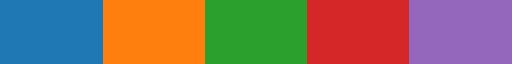

In [41]:
custom_cmap

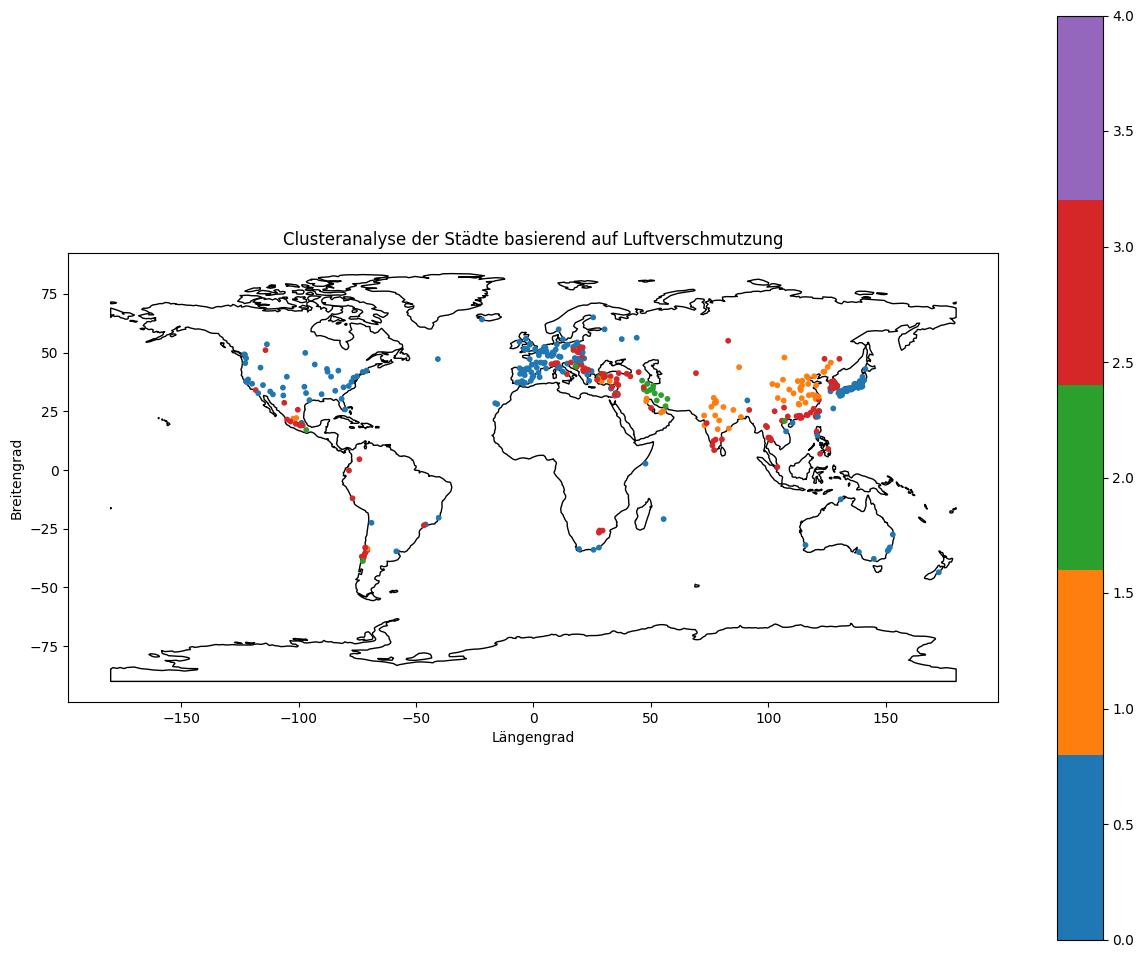

In [42]:
# Plot erstellen
fig, ax = plt.subplots(figsize=(15, 12))

# Umrisse der Weltkarte plotten
world.plot(ax=ax, color='white', edgecolor='black')

# Städte als farbige Punkte nach Cluster einfärben
scatter = gdf_cities.plot(column="Cluster", cmap=custom_cmap, ax=ax, markersize=10, legend=True, alpha=1.0)

# Titel & Achsen
plt.title("Clusteranalyse der Städte basierend auf Luftverschmutzung")
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")

plt.savefig("../Images/cluster_plot.png", dpi=300, bbox_inches="tight")

plt.show()



## Interpretation der Cluster



In [43]:
cluster_summary = df_pollutants_with_cluster_numbers.groupby("Cluster").mean()
cluster_summary


,Co,No2,O3,So2,Pm10,Pm25
Cluster,,,,,,
0,2.45,7.84,21.40,2.31,16.74,37.15
1,7.79,15.25,22.54,6.48,66.22,107.36
2,21.20,19.72,15.91,28.45,42.75,60.76
3,6.06,11.24,18.18,4.53,34.25,67.64
4,138.73,4.88,38.37,1.11,35.15,58.36


In [ ]:
# Städte in Cluster 0 anzeigen (Industrienationen mit Emissionsregulationen und wenig Schwerindustrie IN den Städten)
df_cluster_0 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 0]

print(df_cluster_0.index.tolist())

['Adelaide', 'Akita', 'Albuquerque', 'Amiens', 'Amsterdam', 'Antwerpen', 'Athens', 'Atlanta', 'Augsburg', 'Baltimore', 'Barcelona', 'Belfast', 'Berlin', 'Bilbao', 'Boise', 'Bordeaux', 'Boston', 'Brisbane', 'Bristol', 'Brussels', 'Budapest', 'Buenos aires', 'Burgos', 'Bydgoszcz', 'Calama', 'Cardiff', 'Castelló de la plana', 'Charleroi', 'Charlotte', 'Chiba', 'Chicago', 'Christchurch', 'Clermont-ferrand', 'Copenhagen', 'Córdoba', 'Dallas', 'Darmstadt', 'Darwin', 'Debrecen', 'Denver', 'Detroit', 'Donostia / san sebastián', 'East london', 'Edinburgh', 'Edmonton', 'El paso', 'Florence', 'Fresno', 'Fukuoka', 'Gasteiz / vitoria', 'Gdańsk', 'Gent', 'Gifu-shi', 'Granada', 'Győr', 'Haarlem', 'Haifa', 'Haikou', 'Haiphong', 'Hamburg', 'Hamilton', 'Hartford', 'Hiroshima', 'Houston', 'Hsinchu', 'Huelva', 'Huế', 'Indianapolis', 'Jackson', 'Jacksonville', 'Jeju city', 'Jerusalem', 'Kagoshima', 'Kanazawa', 'Karlsruhe', 'Kassel', 'Kecskemét', 'Keelung', 'Kobe', 'Kochi', 'Kumamoto', 'Kyoto', 'Las palmas 

<Axes: xlabel='Cluster', ylabel='Pm25'>

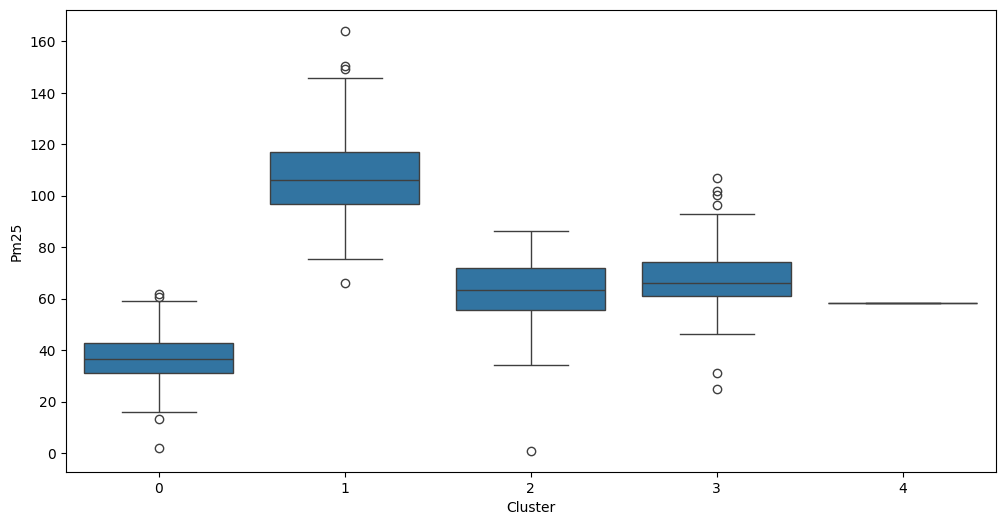

In [52]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="Pm25", data=df_pollutants_with_cluster_numbers)

In [ ]:
# Städte in Cluster 1 anzeigen (höchste Luftverschmutzung)
df_cluster_1 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 1]

print(df_cluster_1.index.tolist())

['Abu dhabi', 'Aguascalientes', 'Anyang', 'Beijing', 'Bhopal', 'Bursa', 'Chandigarh', 'Changchun', 'Changsha', 'Changzhou', 'Chengdu', 'Chongqing', 'Delhi', 'Denizli', 'Dubai', 'Fushun', 'Gandhinagar', 'Ghāziābād', 'Hangzhou', 'Harbin', 'Hefei', 'Hyderabad', 'Hāpur', 'Jaipur', 'Jinan', 'Khorramshahr', 'Kolkata', 'Konya', 'Lanzhou', 'Lucknow', 'Mumbai', 'Muzaffarnagar', 'Nagpur', 'Nanchang', 'Nanjing', 'Patna', 'Petaẖ tiqwa', 'Qingdao', 'Qinhuangdao', 'San luis potosí', 'Santiago', 'Shanghai', 'Shenyang', 'Shijiazhuang', 'Shiyan', 'Suzhou', 'Taiyuan', 'Tianjin', 'Ulan bator', 'Visakhapatnam', 'Wuhan', 'Wuxi', 'Xining', 'Xinxiang', 'Xi’an', 'Xuchang', 'Yinchuan', 'Zhengzhou', 'Zhuzhou', 'Ürümqi', 'Ḩawallī']


In [ ]:
# Städte in Cluster 2 anzeigen (Schwefeldioxid-Cluster; industrielle Emissionen, aber auch Vulkanaktivität)
df_cluster_2 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 2]

print(df_cluster_2.index.tolist())

['Adapazarı', 'Arāk', 'Ashdod', 'Balıkesir', 'Bandar abbas', 'Hạ long', 'Isfahan', 'Karaj', 'Kerman', 'Kermanshah', 'Khorramabad', 'Oaxaca', 'Qom', 'Shiraz', 'Tabriz', 'Temuco', 'Yazd', 'Zanjān', 'Zenica']


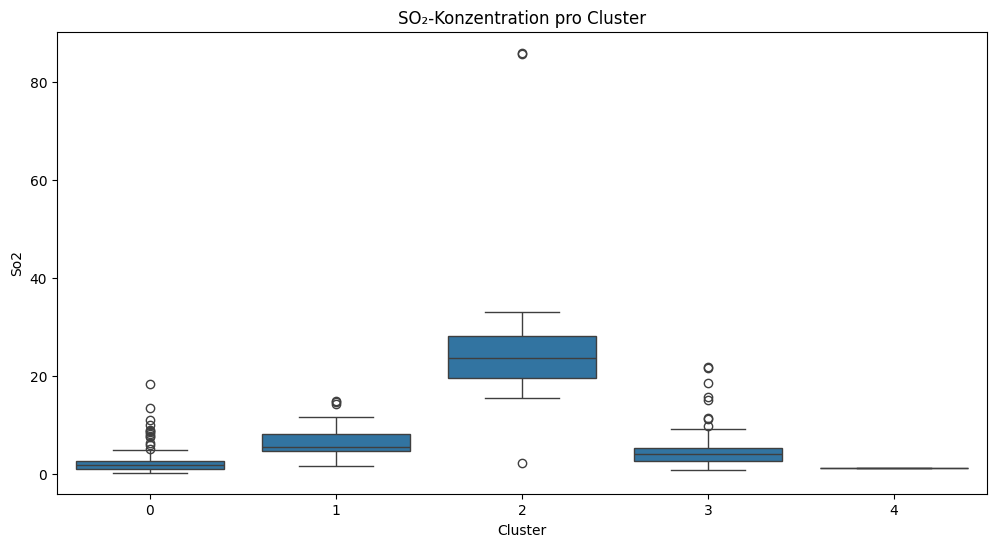

In [56]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="So2", data=df_pollutants_with_cluster_numbers)
plt.title("SO₂-Konzentration pro Cluster")
plt.show()

In [ ]:
# Städte in Cluster 3 anzeigen (mittlere Luftverschmutzung mit Ausreißern)
df_cluster_3 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 3]

print(df_cluster_3.index.tolist())

['Adana', 'Amman', 'Andong', 'Ankara', 'Antakya', 'Baguio', 'Bangkok', 'Belgrade', 'Bengaluru', 'Bogotá', 'Brescia', 'Busan', 'Butuan', 'Calgary', 'Changwon', 'Chennai', 'Cheongju-si', 'Chiang mai', 'Chihuahua', 'Chillán', 'Chon buri', 'Chuncheon', 'Concepción', 'Cuernavaca', 'Daegu', 'Daejeon', 'Dammam', 'Dongguan', 'Douliu', 'Erzurum', 'Eskişehir', 'Foshan', 'Fuzhou', 'Guadalajara', 'Guangzhou', 'Guiyang', 'Gwangju', 'Hanoi', 'Hegang', 'Hong kong', 'Incheon', 'Irbid', 'Istanbul', 'İzmir', 'İzmit', 'Jeonju', 'Jieyang', 'Johannesburg', 'Kaohsiung', 'Katowice', 'Kayseri', 'Kielce', 'Kraków', 'Kunming', 'Kütahya', 'Lampang', 'Lima', 'Los angeles', 'Los ángeles', 'Macau', 'Mexico city', 'Middelburg', 'Milan', 'Miskolc', 'Mokpo', 'Monterrey', 'Morelia', 'Mysore', 'Nakhon pathom', 'Nanning', 'Naples', 'Nashik', 'Netanya', 'Nicosia', 'Ningbo', 'Niš', 'Novi sad', 'Novosibirsk', 'Parma', 'Pohang', 'Pretoria', 'Pristina', 'Puebla', 'Qiqihar', 'Quilpué', 'Quito', 'Rancagua', 'Rayong', 'Samsun'

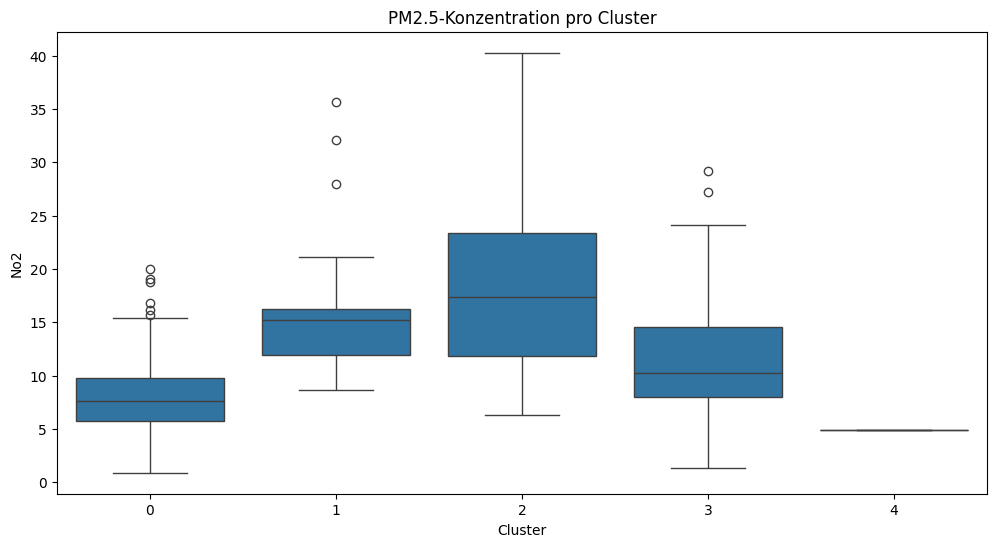

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="No2", data=df_pollutants_with_cluster_numbers)
plt.title("PM2.5-Konzentration pro Cluster")
plt.show()

In [ ]:
# Städte in Cluster 4 anzeigen (Ashkelon, ungewöhnlich hoher CO-Wert)
df_cluster_4 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 4]

print(df_cluster_4.index.tolist())

['Ashkelon']


In [60]:
ashkelon_values = df_pollutants_with_cluster_numbers.loc["Ashkelon"]
ashkelon_values

Co        138.73
No2         4.88
O3         38.37
So2         1.11
Pm10       35.15
Pm25       58.36
Cluster     4.00
Name: Ashkelon, dtype: float64

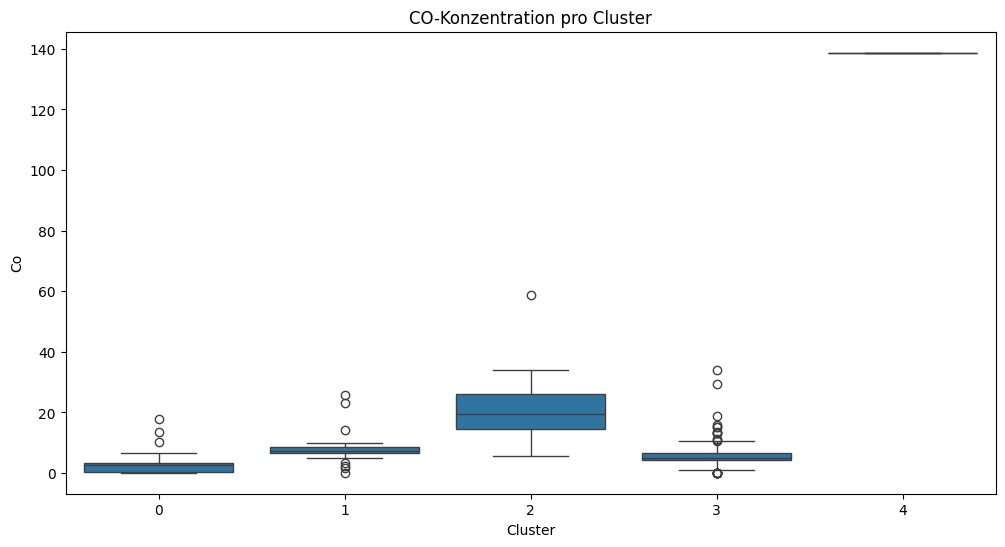

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="Co", data=df_pollutants_with_cluster_numbers)
plt.title("CO-Konzentration pro Cluster")
plt.show()